# "Querido, qual filme vamos ver na próxima vez?"

Este Notebook possui o código de desenvolvimento para um Sistema de Recomendação de filmes para minnha Esposa.

In [1]:
import time
import datetime
import random
import pandas as pd
import numpy as np
from surprise import SVD, BaselineOnly, Reader, Dataset
from surprise.model_selection import GridSearchCV, cross_validate, KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

MY_SEED = 42
def set_cell_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

## Carregando dados

In [2]:
dataset = 'ml-latest-small'

In [3]:
%%time
df_ratings = pd.read_csv(f'{dataset}/ratings.csv',
                        dtype={'userId':str, 'movieId':str, 'rating':float})

df_ratings.drop('timestamp', axis=1, inplace=True)
display(df_ratings.head())

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


CPU times: user 66.6 ms, sys: 11.3 ms, total: 77.9 ms
Wall time: 77.4 ms


In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
userId     100836 non-null object
movieId    100836 non-null object
rating     100836 non-null float64
dtypes: float64(1), object(2)
memory usage: 2.3+ MB


In [5]:
%%time
df_movies = pd.read_csv(f'{dataset}/movies.csv', dtype=str)

display(df_movies.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


CPU times: user 24.8 ms, sys: 7.22 ms, total: 32 ms
Wall time: 30.5 ms


### Criando dataset de notas da Esposa

In [6]:
def add_rating(userId:str, movie_name:str, rating:float):
    """
    Adiciona a nota de um userId referente a filme.
    
    Parameters:
        
        userId: Id do usuário.
        movie_name: Nome do filme. Aceita Expressão Regular
        rating: Nota de 0.5 a 5 de 0.5 em 0.5.   
    """
    # Procura o filme
    movie_details = df_movies[df_movies['title'].str.contains(movie_name)]
    
    if movie_details.shape[0] == 0:
        raise Exception('Não foi encontrado filme com este nome')
    elif movie_details.shape[0] >= 2:
        msg = 'Foram encontrados mais de um filme.\n'
        msg += '\n'.join(movie_details.title)
        raise Exception(msg)
        
    last_index = max(df_ratings.index) + 1
    
    df_ratings.loc[last_index, 'userId'] = userId
    df_ratings.loc[last_index, 'movieId'] = movie_details['movieId'].values[0]
    df_ratings.loc[last_index, 'rating'] = rating
    
    df_ratings.reset_index(inplace=True, drop=True)

In [7]:
esposa_notas = [
    ['Hidden Figures', 4],
    ['Sing .2016.', 4],
    ['Inside Out.*2015', 4],
    ['King.s Speech.*2010.', 5],
    ['A.I. Artificial Intelligence', 4],
    ['Pursuit of Happyness', 5],
    ['Incredibles.*2004', 5],
    ['Bicentennial Man', 4],
    ['Babe.*1995', 3],
    ['Star Trek.*2009', 3],
    ['Cast Away', 3],
    ['Life of Pi', 2],
    ['Hugo', 4],
    ['Harry Potter.*Stone', 4],
    ['Harry Potter.*Chamber', 3],
    ['Harry Potter.*Prisoner', 2],
    ['Avatar', 4],
    ['Twilight.*2008', 2],
    ['Central do Brasil', 3],
    ['Batman Returns', 2],
    ['Matrix.*99', 3],
    ['Matrix Reload', 1],
    ['Matrix Rev', 0.5],
    ['Theory.*Every', 4],
    ['Brave.*12', 3],
    ['Shrek.*2001', 4],
    ['Shrek 2', 4]
]

In [8]:
for movie_name, rating in esposa_notas:
    add_rating('Esposa', movie_name, rating)

df_ratings.tail()

,userId,movieId,rating
100858,Esposa,6934,0.5
100859,Esposa,117176,4.0
100860,Esposa,95167,3.0
100861,Esposa,4306,4.0
100862,Esposa,8360,4.0


In [9]:
df_ratings.query("userId == 'Esposa'")\
    .merge(df_movies)\
    .drop('movieId', axis=1)\
    .sort_values('rating', ascending=False)\
    .reset_index(drop=True)

,userId,rating,title,genres
0,Esposa,5.0,"King's Speech, The (2010)",Drama
1,Esposa,5.0,"Pursuit of Happyness, The (2006)",Drama
2,Esposa,5.0,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy
3,Esposa,4.0,Hidden Figures (2016),Drama
4,Esposa,4.0,Hugo (2011),Children|Drama|Mystery
5,Esposa,4.0,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
6,Esposa,4.0,The Theory of Everything (2014),Drama|Romance
7,Esposa,4.0,Avatar (2009),Action|Adventure|Sci-Fi|IMAX
8,Esposa,4.0,Sing (2016),Animation|Children|Comedy
9,Esposa,4.0,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy


### Convertendo *Ratings* para formato do `surprise`

Transformando para ser usado pela biblioteca `surprise`.

In [10]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], 
                            reader)

full_trainset = data.build_full_trainset()

## Verificando Algoritmos

In [11]:
# Implementação baseada em
# https://github.com/NicolasHug/Surprise/blob/master/examples/benchmark.py
set_cell_seed(MY_SEED)

# Os algortimos para verificar
classes = (SVD, BaselineOnly)

kf = KFold(random_state=MY_SEED)  # certifica que as dobras serão as mesmas

table = []
for klass in classes:
    start = time.time()
    out = cross_validate(klass(), data, ['rmse', 'mae'], kf, n_jobs=-1)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    mean_rmse = '{:.3f}'.format(np.mean(out['test_rmse']))
    mean_mae = '{:.3f}'.format(np.mean(out['test_mae']))

    new_line = [klass.__name__, mean_rmse, mean_mae, cv_time]
    table.append(new_line)

header = ['Algoritmo',
          'RMSE',
          'MAE',
          'Tempo'
          ]
pd.DataFrame(table, columns=header)

,Algoritmo,RMSE,MAE,Tempo
0,SVD,0.874,0.672,0:00:25
1,BaselineOnly,0.873,0.673,0:00:10


Os modelos Baseline e SVD performaram de forma similar. Vamos testar o Baseline:

## Treinando modelo Baseline e fazendo recomendações:

Já validamos o mdelo usando Validação Cruzada, assim vamos treinar o modelo usando os parâmetros padrões:

In [12]:
%%time
set_cell_seed(MY_SEED)

algo_base=BaselineOnly()
algo_base.fit(full_trainset)

Estimating biases using als...
CPU times: user 218 ms, sys: 11.7 ms, total: 230 ms
Wall time: 227 ms


Criamos uma função para retornar N filmes para recomendar para dado usuário baseado nas maiores notas preditas:

In [13]:
def get_rec_movies(user_id:str, algoritmo, n_top: int =10) -> pd.DataFrame:
    """
    Obtém uma lista de recomendação para N filmes para um 
    usuário.
    
    Parameters:
        user_id: o ID do usuário
        n_top: O número de filmes desejados
        
    Returns:
        Um DataFrame com o ID dos filmes, nome e gênero.
    """
    all_movie_id = set(df_ratings['movieId'].unique())
    rated_movies = set(df_ratings.query(f"userId == '{user_id}'")['movieId'].values)
    unrated_movies = list(all_movie_id.difference(rated_movies))

    # top N movies
    top_movies = pd.Series(unrated_movies, index=unrated_movies)\
                    .map(lambda movie_id:  algoritmo.predict(user_id, movie_id).est)\
                    .sort_values(ascending=False)[:n_top]\
                    .rename('pred_rating')\
                    .reset_index()\
                    .rename(columns=dict(index='movieId'))\
                    .merge(df_movies, on='movieId')\
                    .set_index('movieId')
    
    return top_movies[['title', 'genres', 'pred_rating']]

In [14]:
get_rec_movies('Esposa', algo_base)

,title,genres,pred_rating
movieId,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.180988
750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.081720
2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.061134
858,"Godfather, The (1972)",Crime|Drama,4.052207
1204,Lawrence of Arabia (1962),Adventure|Drama|War,4.050292
50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.040741
904,Rear Window (1954),Mystery|Thriller,4.028117
1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.009207
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.008859


### SVD

Vamos inicialmente tunar o modelo para encontrar os melhores hiperparâmetros:

In [15]:
%%time 
set_cell_seed(MY_SEED)

param_grid = {
    'n_factors': [10, 100, 200, 400],  
    'lr_all': [0.002, 0.005, 0.007, 0.009],
    'n_epochs':[20, 100, 200, 400]
}

gs = GridSearchCV(SVD, param_grid, measures=['mae', 'rmse'], cv=5, n_jobs=-1)

gs.fit(data)

CPU times: user 18min 8s, sys: 9.24 s, total: 18min 17s
Wall time: 3h 55min 48s


In [16]:
# best scores
print(f"RMSE:{gs.best_score['rmse']:.3f}")

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
      
###
# best scores
print(f"MAE:{gs.best_score['mae']:.3f}")

# combination of parameters that gave the best MAE score
print(gs.best_params['mae'])      
      

RMSE:0.855
{'n_factors': 400, 'lr_all': 0.009, 'n_epochs': 200}
MAE:0.655
{'n_factors': 400, 'lr_all': 0.005, 'n_epochs': 400}


In [17]:
df_results = pd.DataFrame.from_dict(gs.cv_results)
df_results.columns = df_results.columns.str.replace('param_','')

df_results.head()

,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,mean_test_mae,std_test_mae,rank_test_mae,split0_test_rmse,split1_test_rmse,...,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,n_factors,lr_all,n_epochs
0,0.679653,0.677802,0.673846,0.682007,0.683895,0.679441,0.003477,48,0.883802,0.878362,...,0.004782,43,2.266054,0.718848,0.359196,0.111472,"{'n_factors': 10, 'lr_all': 0.002, 'n_epochs':...",10,0.002,20
1,0.666773,0.663461,0.659803,0.666279,0.672759,0.665815,0.004267,23,0.872954,0.867518,...,0.006197,27,20.730310,1.187870,0.488778,0.068122,"{'n_factors': 10, 'lr_all': 0.002, 'n_epochs':...",10,0.002,100
2,0.681422,0.686728,0.678331,0.678874,0.688445,0.682760,0.004113,51,0.899838,0.902315,...,0.005869,54,38.152713,1.328178,0.431962,0.060469,"{'n_factors': 10, 'lr_all': 0.002, 'n_epochs':...",10,0.002,200
3,0.701837,0.705036,0.703347,0.706422,0.709356,0.705200,0.002590,57,0.927226,0.929070,...,0.003985,57,71.555777,2.297816,0.465075,0.063587,"{'n_factors': 10, 'lr_all': 0.002, 'n_epochs':...",10,0.002,400
4,0.669423,0.666748,0.663184,0.669300,0.675170,0.668765,0.003923,29,0.873287,0.865790,...,0.005523,26,3.851743,0.421492,0.561719,0.057895,"{'n_factors': 10, 'lr_all': 0.005, 'n_epochs':...",10,0.005,20


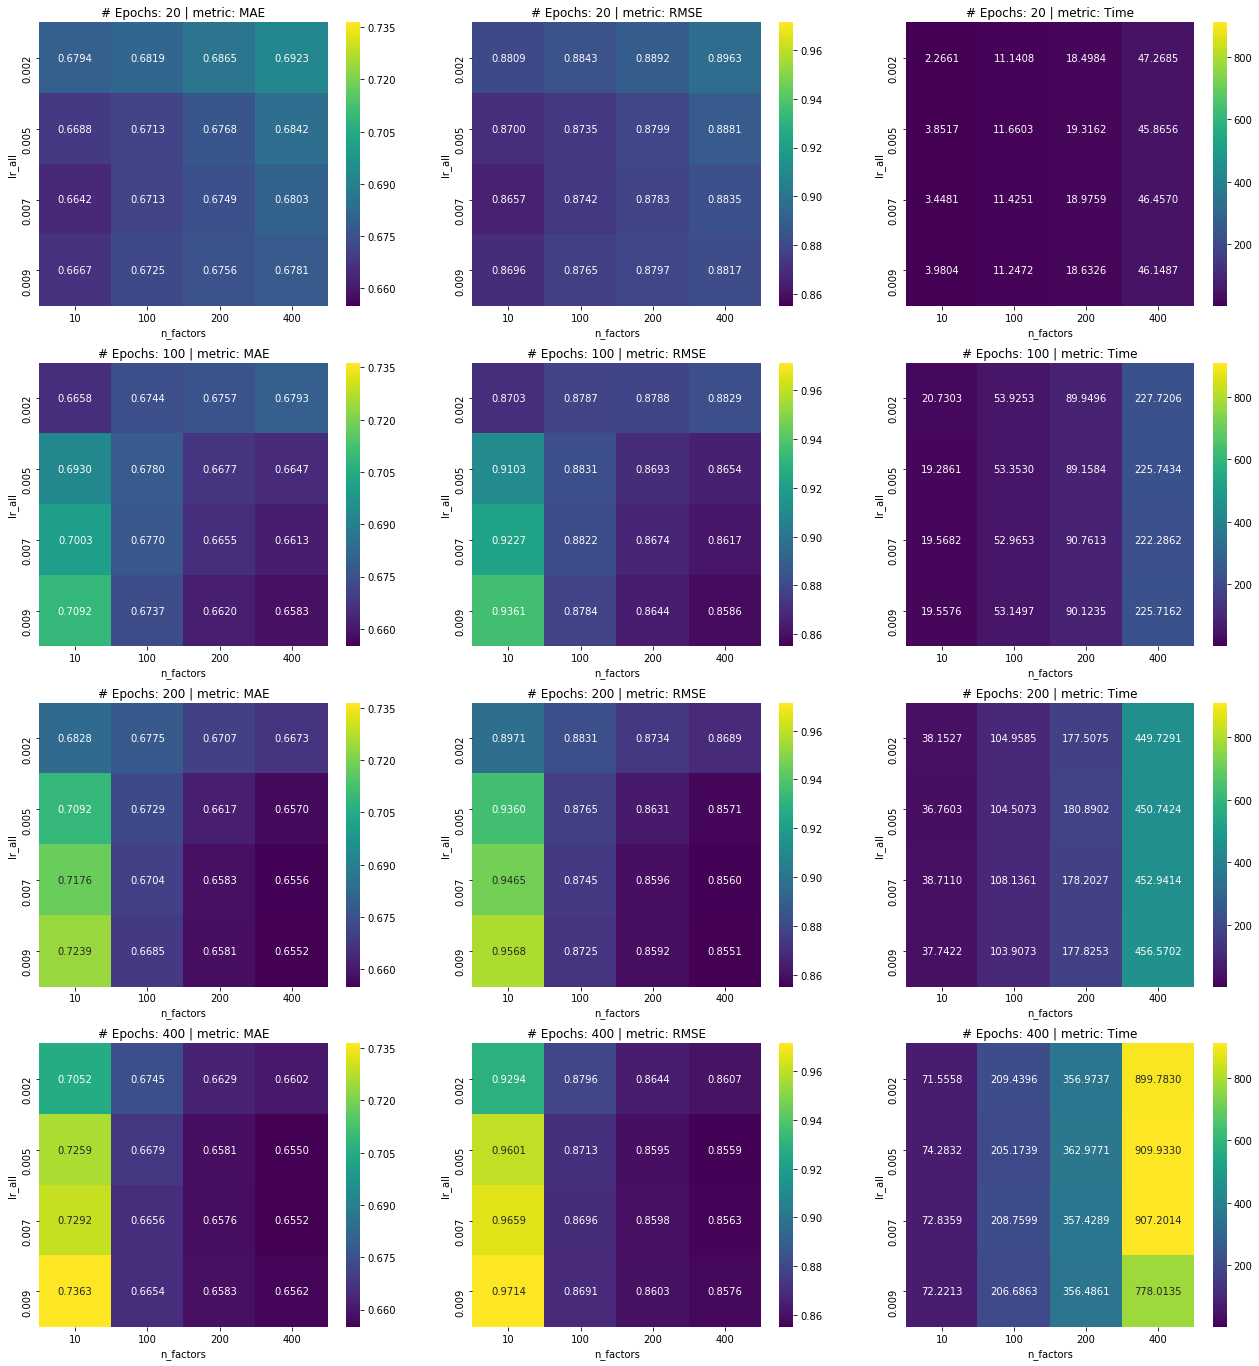

In [18]:
n_epochs = len(param_grid['n_epochs'])
fig, axes = plt.subplots(nrows=n_epochs, ncols=3, figsize=(22, 6*n_epochs))

for ax_row, n_epoch in zip(axes, param_grid['n_epochs']):
    for ax, metric in zip(ax_row, ['mae', 'rmse', 'time']):
    
        parameter = f'mean_test_{metric}'  if metric != 'time' else f'mean_fit_{metric}'
            
        ax = sns.heatmap(
            df_results.query(f'n_epochs =={n_epoch}')\
                      .pivot_table(columns='n_factors', index='lr_all', values=parameter),
            annot=True,
            fmt='0.4f',
            vmin= df_results[parameter].min(),
            vmax= df_results[parameter].max(),
            ax=ax,
            cmap='viridis'
        )
        
        metric = metric.capitalize() if metric == 'time' else metric.upper()
        ax.set_title(f'# Epochs: {n_epoch} | metric: {metric}')             


### Treinando modelo com melhor MAE

In [19]:
%%time
set_cell_seed(MY_SEED)

algo_svd_mae = gs.best_estimator['mae']
algo_svd_mae.fit(full_trainset)

CPU times: user 8min 49s, sys: 200 ms, total: 8min 49s
Wall time: 8min 49s


In [20]:
get_rec_movies('Esposa', algo_svd_mae)

,title,genres,pred_rating
movieId,,,
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.739443
1265,Groundhog Day (1993),Comedy|Fantasy|Romance,4.558095
1203,12 Angry Men (1957),Drama,4.550203
1262,"Great Escape, The (1963)",Action|Adventure|Drama|War,4.529004
922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,4.508597
1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western,4.480504
6016,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.421858
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.417879
910,Some Like It Hot (1959),Comedy|Crime,4.389491


### Treinando modelo com melhor RMSE

In [21]:
%%time
set_cell_seed(MY_SEED)

algo_svd_rmse = gs.best_estimator['rmse']
algo_svd_rmse.fit(full_trainset)

CPU times: user 4min 15s, sys: 119 ms, total: 4min 15s
Wall time: 4min 15s


In [22]:
get_rec_movies('Esposa', algo_svd_rmse)

,title,genres,pred_rating
movieId,,,
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.738877
1265,Groundhog Day (1993),Comedy|Fantasy|Romance,4.549247
1203,12 Angry Men (1957),Drama,4.525410
1262,"Great Escape, The (1963)",Action|Adventure|Drama|War,4.520180
922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,4.505926
1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western,4.484268
6016,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.393995
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.386644
232,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,4.367410
